In [2]:
import os
import json
import glob
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from PIL import Image
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
import seaborn as sns 
import time
import random
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchinfo import summary
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows의 경우, 한글 지원 폰트로 설정
plt.rcParams['axes.unicode_minus'] = False       # 음수 기호가 깨지지 않도록 설정

# import wandb
# wandb.login()
# 619d9ad81381985808afa97afb81216d76922b18

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        log_pt = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-log_pt)

        # alpha handling
        if isinstance(self.alpha, (list, torch.Tensor)):
            if isinstance(self.alpha, list):
                self.alpha = torch.tensor(self.alpha, device=inputs.device)
            at = self.alpha[targets]
        else:
            at = self.alpha

        focal_loss = at * ((1 - pt) ** self.gamma) * log_pt

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [4]:
BATCH_SIZE = 64
LR = 1e-4
LR_STEP = 3
LR_GAMMA = 0.9
EPOCH = 1
TRAIN_RATIO = 0.8
criterion_mise = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
criterion_pizi = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
criterion_mosa = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
criterion_mono = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
criterion_biddem = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
criterion_talmo = FocalLoss(alpha=0.25, gamma=2).to(DEVICE)
new_model_train = True
model_type = "MobileVit-XXS_" + datetime.now().strftime("%Y_%m_%d_%H")
dataset = "SCALP"
save_model_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\model\{model_type}_model.pt"
save_history_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\history\{model_type}_history.pt"
save_result_csv_path = rf"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\result\model_results.csv"

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [5]:
class MultiTaskDataset(Dataset):
    def __init__(self, img_dir, json_dir, transform=None):
        self.data = []
        json_files = glob.glob(os.path.join(json_dir, "*.json"))
        for json_file in json_files:
            with open(json_file, 'r') as f:
                data_part = json.load(f)
                if isinstance(data_part, dict):
                    self.data.append(data_part)
                else:
                    self.data.extend(data_part)
        
        # 라벨이 모두 0인 샘플 삭제 (6개의 질환 모두 0인 경우)
        filtered_data = []
        for sample in self.data:
            # 각 질환 라벨을 정수로 변환하여 리스트로 생성
            labels = [int(sample[f"value_{i+1}"]) for i in range(6)]
            # 하나라도 0이 아닌 값이 있으면 추가
            if any(label != 0 for label in labels):  # 686개
                filtered_data.append(sample)
        self.data = filtered_data
        
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        img_path = os.path.join(self.img_dir, sample["image_file_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        labels = [int(sample[f"value_{i+1}"]) for i in range(6)]
        labels = torch.tensor(labels, dtype=torch.long)
        return image, labels


# 2. 데이터 전처리: 이미지 크기 조정, 텐서 변환, 정규화
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
image_path = r"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\data\image"     # 이미지 파일들이 저장된 폴더 경로
label_path = r"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\data\label"      # 여러 JSON 파일이 저장된 폴더 경로

total_DS = MultiTaskDataset(image_path, label_path, transform=data_transforms)


NoT = int(len(total_DS) * TRAIN_RATIO)  # NoT = Number of Train
NoV = int(len(total_DS) * (1 - TRAIN_RATIO) / 2)  # NoV = Number of Validation
NoTest = int(len(total_DS)) - NoT - NoV

train_DS, val_DS, test_DS = random_split(total_DS, [NoT, NoV, NoTest])


train_DL = DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=False)
test_DL = DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=False)

len(train_DS), len(val_DS), len(test_DS)

(72376, 9046, 9048)

In [7]:
# import torch
# from collections import Counter

# # 각 질환(label)별 클래스 분포를 저장할 리스트
# value_counters = [Counter() for _ in range(6)]

# # total_DS의 모든 샘플에 대해 반복하면서 카운트
# for _, labels in total_DS:
#     for i in range(6):
#         value_counters[i][int(labels[i])] += 1

# # 클래스 분포를 torch.tensor 형태로 변환
# mise_counts = torch.tensor([value_counters[0][i] for i in range(4)], dtype=torch.float)
# pizi_counts = torch.tensor([value_counters[1][i] for i in range(4)], dtype=torch.float)
# mosa_counts = torch.tensor([value_counters[2][i] for i in range(4)], dtype=torch.float)
# mono_counts = torch.tensor([value_counters[3][i] for i in range(4)], dtype=torch.float)
# biddem_counts = torch.tensor([value_counters[4][i] for i in range(4)], dtype=torch.float)
# talmo_counts = torch.tensor([value_counters[5][i] for i in range(4)], dtype=torch.float)

# # 결과 확인
# print(f"mise_counts: {mise_counts}")
# print(f"pizi_counts: {pizi_counts}")
# print(f"mosa_counts: {mosa_counts}")
# print(f"mono_counts: {mono_counts}")
# print(f"biddem_counts: {biddem_counts}")
# print(f"talmo_counts: {talmo_counts}")

# 결과
mise_counts =  torch.tensor([74766.,  5702.,  7062.,  2940.])
pizi_counts =  torch.tensor([17450., 36193., 31945.,  4882.])
mosa_counts =  torch.tensor([28875., 39217., 16859.,  5519.])
mono_counts =  torch.tensor([86221.,  2841.,   981.,   427.])
biddem_counts =  torch.tensor([53865., 21415., 12287.,  2903.])
talmo_counts =  torch.tensor([66884., 17549.,  4959.,  1078.])

In [8]:
mise_alpha = (1.0 / mise_counts)
mise_alpha = (mise_alpha / mise_alpha.sum()).to(DEVICE)

pizi_alpha = (1.0 / pizi_counts)
pizi_alpha = (pizi_alpha / pizi_alpha.sum()).to(DEVICE)

mosa_alpha = (1.0 / mosa_counts)
mosa_alpha = (mosa_alpha / mosa_alpha.sum()).to(DEVICE)

mono_alpha = (1.0 / mono_counts)
mono_alpha = (mono_alpha / mono_alpha.sum()).to(DEVICE)

biddem_alpha = (1.0 / biddem_counts)
biddem_alpha = (biddem_alpha / biddem_alpha.sum()).to(DEVICE)

talmo_alpha = (1.0 / talmo_counts)
talmo_alpha = (talmo_alpha / talmo_alpha.sum()).to(DEVICE)

criterion_mise = FocalLoss(alpha=mise_alpha, gamma=2).to(DEVICE)
criterion_pizi = FocalLoss(alpha=pizi_alpha, gamma=2).to(DEVICE)
criterion_mosa = FocalLoss(alpha=mosa_alpha, gamma=2).to(DEVICE)
criterion_mono = FocalLoss(alpha=mono_alpha, gamma=2).to(DEVICE)
criterion_biddem = FocalLoss(alpha=biddem_alpha, gamma=2).to(DEVICE)
criterion_talmo = FocalLoss(alpha=talmo_alpha, gamma=2).to(DEVICE)

criterion_list = [
    criterion_mise, criterion_pizi, criterion_mosa,
    criterion_mono, criterion_biddem, criterion_talmo
]

In [9]:
import torch
import torch.nn as nn
from transformers import MobileViTForImageClassification

# 2. MobileViT 백본: MobileViTForImageClassification에서 Dropout과 Linear 레이어를 제외한 부분 사용
class MobileViTBackbone(nn.Module):
    def __init__(self, model_name="apple/mobilevit-xx-small"):
        super(MobileViTBackbone, self).__init__()
        # MobileViTForImageClassification 전체를 불러오지만,
        # forward 시에 output_hidden_states 옵션을 사용하여 backbone의 중간 feature map을 반환합니다.
        self.model = MobileViTForImageClassification.from_pretrained(
            model_name,
            output_hidden_states=True
        )
        
        self.model.to(DEVICE)
        # 모델을 평가 모드로 설정하여 dropout 등 비활성화
        self.model.eval()
        # 더미 입력을 통해 마지막 hidden state의 채널 수를 자동으로 결정
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 224, 224).to(DEVICE)  # 배치 크기 1, 채널 3, 이미지 크기 224x224
            outputs = self.model(dummy_input)
            features = outputs.hidden_states[-1]
            self.out_channels = features.shape[1]  # 실제 채널 수 할당
            
    def forward(self, x):
        outputs = self.model(x)
        # hidden_states[-1]를 backbone의 마지막 feature map (예상 shape: [batch, 320, 7, 7])으로 사용
        features = outputs.hidden_states[-1]
        return features

# 3. Inverted Bottleneck Block (MobileNetV2 구조 참고)
class InvertedBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, expansion_factor=6, stride=1):
        """
        Args:
            in_channels: 입력 채널 수
            out_channels: 출력 채널 수
            expansion_factor: 확장 비율 (보통 6)
            stride: stride (대부분 1)
        """
        super(InvertedBottleneckBlock, self).__init__()
        hidden_dim = in_channels * expansion_factor
        self.stride = stride
        self.use_residual = (self.stride == 1 and in_channels == out_channels)
 
        self.conv = nn.Sequential(
            # 1x1 expansion
            nn.Conv2d(in_channels, hidden_dim, kernel_size=1, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # 3x3 depthwise convolution
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm2d(hidden_dim),
            nn.ReLU(inplace=True),
            # 1x1 projection
            nn.Conv2d(hidden_dim, out_channels, kernel_size=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
             
    def forward(self, x):
        out = self.conv(x)
        if self.use_residual:
            out = out + x
        return out

# 4. Multi-Task 모델: MobileViT 백본 + 각 태스크 head (각 head는 두 개의 Inverted Bottleneck Block 후 fc-layer 통과)
class MultiTaskMobileViT(nn.Module):
    def __init__(self, head_channels=64):
        """
        Args:
            backbone: 외부에서 제공하는 백본 (None이면 내부에서 선택)
            num_heads: 태스크 head 개수
            head_channels: 각 head에서 Inverted Bottleneck Block 후의 내부 채널 수 (fc-layer의 입력 차원)
            use_pretrained_backbone: True이면 사전학습된 MobileViT 백본 사용, False이면 Dummy 백본 사용
        """
        super(MultiTaskMobileViT, self).__init__()
        self.backbone = MobileViTBackbone()
        backbone_out_channels = self.backbone.out_channels  # 예시: 320
           
        
        # 각 태스크별 classifier (명확하게 별도의 속성으로 선언)
        self.fc_mise = self._make_task_head(backbone_out_channels, head_channels, out_channels = 4)
        self.fc_pizi = self._make_task_head(backbone_out_channels, head_channels, out_channels = 4)
        self.fc_mosa = self._make_task_head(backbone_out_channels, head_channels, out_channels = 4)
        self.fc_mono = self._make_task_head(backbone_out_channels, head_channels, out_channels = 4)
        self.fc_biddem = self._make_task_head(backbone_out_channels, head_channels, out_channels = 4)
        self.fc_talmo = self._make_task_head(backbone_out_channels, head_channels, out_channels = 4)
        
    def _make_task_head(self, in_channels, head_channels, out_channels = 4):
        return nn.Sequential(InvertedBottleneckBlock(in_channels=in_channels, out_channels=head_channels, expansion_factor=6, stride=1),
                            #  InvertedBottleneckBlock(in_channels=head_channels, out_channels=head_channels, expansion_factor=6, stride=1),
                             nn.AdaptiveAvgPool2d((1, 1)),  # [batch, head_channels, 1, 1]로 축소
                             nn.Flatten(),                  # [batch, head_channels]
                             nn.Linear(head_channels, out_channels)  # 4개 클래스로 분류
                             )
 
    def forward(self, x):
        features = self.backbone(x)  # 예상 shape: [batch, channels, H, W]
        mise_head = self.fc_mise(features)
        pizi_head = self.fc_pizi(features)
        mosa_head = self.fc_mosa(features)
        mono_head = self.fc_mono(features)
        biddem_head = self.fc_biddem(features)
        talmo_head = self.fc_talmo(features)
        return mise_head, pizi_head, mosa_head, mono_head, biddem_head, talmo_head

# 5. 모델 생성 및 테스트 예시
if __name__ == '__main__':
    # use_pretrained_backbone 값을 True로 설정하면 실제 MobileViT 백본 사용, False면 Dummy 사용
    model = MultiTaskMobileViT(head_channels=64).to(DEVICE)
    # 임의의 입력: 배치 크기 1, 채널 3, 이미지 크기 224x224
    input_tensor = torch.randn(1, 3, 224, 224).to(DEVICE)
    outputs = model(input_tensor)
 
    for i, out in enumerate(outputs):
        print(f"Head {i+1} output shape: {out.shape}")


c:\Users\user1\anaconda3\envs\pt_py311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Head 1 output shape: torch.Size([1, 4])
Head 2 output shape: torch.Size([1, 4])
Head 3 output shape: torch.Size([1, 4])
Head 4 output shape: torch.Size([1, 4])
Head 5 output shape: torch.Size([1, 4])
Head 6 output shape: torch.Size([1, 4])


In [10]:
summary(model, input_size=(32,3,224,224))

Layer (type:depth-idx)                                                                Output Shape              Param #
MultiTaskMobileViT                                                                    [32, 4]                   --
├─MobileViTBackbone: 1-1                                                              [32, 80, 7, 7]            --
│    └─MobileViTForImageClassification: 2-1                                           [32, 16, 112, 112]        --
│    │    └─MobileViTModel: 3-1                                                       [32, 16, 112, 112]        951,024
│    │    └─Dropout: 3-2                                                              [32, 320]                 --
│    │    └─Linear: 3-3                                                               [32, 1000]                321,000
├─Sequential: 1-2                                                                     [32, 4]                   --
│    └─InvertedBottleneckBlock: 2-2                              

In [11]:
# 입력 데이터 한 배치 가져오기
x_batch, _ = next(iter(train_DL))

# 모델의 출력 얻기
outputs = model(x_batch.to(DEVICE))

# 각 태스크(헤드) 별 출력 shape 확인
for idx, output in enumerate(outputs, 1):
    print(f'Task {idx} output shape: {output.shape}')


Task 1 output shape: torch.Size([64, 4])
Task 2 output shape: torch.Size([64, 4])
Task 3 output shape: torch.Size([64, 4])
Task 4 output shape: torch.Size([64, 4])
Task 5 output shape: torch.Size([64, 4])
Task 6 output shape: torch.Size([64, 4])


In [12]:
def Train(model, train_DL, val_DL, criterion_list, optimizer, 
          EPOCH, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, **kwargs):
    
    if 'LR_STEP' in kwargs:  # kwargs에 'LR_STEP'이 있으면
        scheduler = StepLR(optimizer, step_size = kwargs['LR_STEP'], gamma = kwargs['LR_GAMMA'])
    else:
        scheduler = None
        
    loss_history = {'train':{'total':[], 
                             'mise':[], 
                             'pizi':[], 
                             'mosa':[], 
                             'mono':[], 
                             'biddem':[], 
                             'talmo':[]}, 
                    
                    'val':{'total':[], 
                           'mise':[], 
                           'pizi':[], 
                           'mosa':[], 
                           'mono':[], 
                           'biddem':[], 
                           'talmo':[]}} # total_loss값을 저장할 딕셔너리
    
    acc_history = {'train':{'total':[], 
                            'mise':[], 
                            'pizi':[], 
                            'mosa':[], 
                            'mono':[], 
                            'biddem':[], 
                            'talmo':[]}, 
                    
                    'val':{'total':[], 
                            'mise':[], 
                            'pizi':[], 
                            'mosa':[], 
                            'mono':[], 
                            'biddem':[], 
                            'talmo':[]}} # accuracy값을 저장할 딕셔너리
    
    best_loss = float('inf')  # best_loss 초기화

    for epoch in range(EPOCH):
        epoch_start = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Epoch: {epoch+1}/{EPOCH}, current_LR = {current_lr}")
        
        train_epoch_loss, train_epoch_loss_mise, train_epoch_loss_pizi, train_epoch_loss_mosa, train_epoch_loss_mono, train_epoch_loss_biddem, train_epoch_loss_talmo,\
        train_epoch_acc, train_task_acc = loss_epoch(model, train_DL, criterion_list, optimizer)
        
        loss_history['train']['total'] += [train_epoch_loss]
        loss_history['train']['mise'] += [train_epoch_loss_mise]
        loss_history['train']['pizi'] += [train_epoch_loss_pizi]
        loss_history['train']['mosa'] += [train_epoch_loss_mosa]
        loss_history['train']['mono'] += [train_epoch_loss_mono]
        loss_history['train']['biddem'] += [train_epoch_loss_biddem]
        loss_history['train']['talmo'] += [train_epoch_loss_talmo]
        
        acc_history['train']['total'] += [train_epoch_acc]
        acc_history['train']['mise'] += [train_task_acc[0]]
        acc_history['train']['pizi'] += [train_task_acc[1]]
        acc_history['train']['mosa'] += [train_task_acc[2]]
        acc_history['train']['mono'] += [train_task_acc[3]]
        acc_history['train']['biddem'] += [train_task_acc[4]]
        acc_history['train']['talmo'] += [train_task_acc[5]]
        
        model.eval()  # test mode로 전환
        with torch.no_grad():
            val_epoch_loss, val_epoch_loss_mise, val_epoch_loss_pizi, val_epoch_loss_mosa, val_epoch_loss_mono, val_epoch_loss_biddem, val_epoch_loss_talmo,\
            val_epoch_acc, val_task_acc = loss_epoch(model, val_DL, criterion_list)

            loss_history['val']['total'] += [val_epoch_loss]
            loss_history['val']['mise'] += [val_epoch_loss_mise]
            loss_history['val']['pizi'] += [val_epoch_loss_pizi]
            loss_history['val']['mosa'] += [val_epoch_loss_mosa]
            loss_history['val']['mono'] += [val_epoch_loss_mono]
            loss_history['val']['biddem'] += [val_epoch_loss_biddem]
            loss_history['val']['talmo'] += [val_epoch_loss_talmo]

            acc_history['val']['total'] += [val_epoch_acc]
            acc_history['val']['mise'] += [val_task_acc[0]]
            acc_history['val']['pizi'] += [val_task_acc[1]]
            acc_history['val']['mosa'] += [val_task_acc[2]]
            acc_history['val']['mono'] += [val_task_acc[3]]
            acc_history['val']['biddem'] += [val_task_acc[4]]
            acc_history['val']['talmo'] += [val_task_acc[5]]
            
            if val_epoch_loss < best_loss:  # early stopping
                best_loss = val_epoch_loss
                
                # optimizer도 저장하면, 재학습 시 optimizer의 상태도 그대로 불러와서 '이어서' 학습할 수 있음.
                # Adam, Momentum, RMSprop 등의 optimizer는 이전 gradient를 누적하여 가중치를 업데이트하기 때문에, optimizer의 상태도 저장해야 함.
                torch.save({'model_params' : model.state_dict(),
                            'epoch' : epoch + 1,
                            'optimizer' : optimizer,
                            'scheduler' : scheduler,}, save_model_path)
                print('model save!')
        if 'LR_STEP' in kwargs:
            scheduler.step()  # scheduler.step()을 통해 learning rate를 조절
        
        # print loss
        print(f"train loss: {round(train_epoch_loss,5)}, "
              f"val loss: {round(val_epoch_loss,5)} \n"
              f"train acc: {round(train_epoch_acc,1)} %, "
              f"val acc: {round(val_epoch_acc,1)} %, time: {round(time.time()-epoch_start)} s")
        print("-"*20)

    torch.save({"loss_history": loss_history,
                "acc_history": acc_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE,
                "TRAIN_RATIO": TRAIN_RATIO,}, save_history_path)
        
    return loss_history, acc_history


def loss_epoch(model, DL, criterion_list, optimizer = None):
    epoch_loss = 0.0
    epoch_loss_mise = 0.0
    epoch_loss_pizi = 0.0
    epoch_loss_mosa = 0.0
    epoch_loss_mono = 0.0
    epoch_loss_biddem = 0.0
    epoch_loss_talmo = 0.0

    # 정확도 계산을 위한 변수 초기화
    task_correct = [0] * 6
    NoD = len(DL.dataset)  # Number of Data
    total_correct = 0
    
    criterion_mise, criterion_pizi, criterion_mosa,\
    criterion_mono, criterion_biddem, criterion_talmo = criterion_list
    
    for x_batch, y_batch in tqdm(DL, leave = False):
        x_batch = x_batch.to(DEVICE)
        y_batch = y_batch.to(DEVICE)
        
        # forward
        mise_head, pizi_head, mosa_head, mono_head, biddem_head, talmo_head = model(x_batch)

        # 각 태스크별 손실 계산
        loss_mise = criterion_mise(mise_head, y_batch[:, 0])
        loss_pizi = criterion_pizi(pizi_head, y_batch[:, 1])
        loss_mosa = criterion_mosa(mosa_head, y_batch[:, 2])
        loss_mono = criterion_mono(mono_head, y_batch[:, 3])
        loss_biddem = criterion_biddem(biddem_head, y_batch[:, 4])
        loss_talmo = criterion_talmo(talmo_head, y_batch[:, 5])
        
        # 총 손실 계산
        loss = loss_mise + loss_pizi + loss_mosa + loss_mono + loss_biddem + loss_talmo
        
        # backprobagation(weight update)
        if optimizer is not None:
            optimizer.zero_grad() # gradient 초기화. 해주지 않으면 누적해서(계속 더해짐) 업데이트 됨. => gradient explosion
            loss.backward()  # gradient 계산(backpropagation)
            optimizer.step()  # parameter 업데이트
            
        # accumulate loss
        batch_loss = loss.item() * x_batch.shape[0]  
        
        epoch_loss += batch_loss
        epoch_loss_mise += loss_mise.item() * x_batch.shape[0]
        epoch_loss_pizi += loss_pizi.item() * x_batch.shape[0]
        epoch_loss_mosa += loss_mosa.item() * x_batch.shape[0]
        epoch_loss_mono += loss_mono.item() * x_batch.shape[0]
        epoch_loss_biddem += loss_biddem.item() * x_batch.shape[0]
        epoch_loss_talmo += loss_talmo.item() * x_batch.shape[0]

        
        # accumulate accuracy
        # 각 태스크별 정확도 계산
        preds = torch.stack([mise_head.argmax(dim=1), 
                             pizi_head.argmax(dim=1),
                             mosa_head.argmax(dim=1),
                             mono_head.argmax(dim=1),
                             biddem_head.argmax(dim=1),
                             talmo_head.argmax(dim=1)],
                            dim=1)
        
        for task in range(6):
            batch_correct = (preds[:, task] == y_batch[:, task]).sum().item()
            task_correct[task] += batch_correct
            total_correct += batch_correct
        
        
    epoch_loss /= NoD  # epoch_loss를 data의 크기로 나눠줌.
                       # 1에포크의 loss를 data의 크기로 나눠줌. => data의 크기에 상관없이 loss를 비교할 수 있게 해줌.
    
    epoch_acc = total_correct / (NoD * 6) * 100  # 전체 개수 x6 (6개의 task)로 나눠줌.
    
    for task in range(6):
        task_correct[task] = (task_correct[task] / NoD) * 100
        
    return epoch_loss, epoch_loss_mise, epoch_loss_pizi, epoch_loss_mosa, epoch_loss_mono, epoch_loss_biddem, epoch_loss_talmo,\
           epoch_acc, task_correct

In [13]:
if new_model_train:
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=LR)
    loss_history, acc_history = Train(model, train_DL, val_DL, criterion_list, optimizer,
                                      EPOCH, BATCH_SIZE, TRAIN_RATIO,
                                      save_model_path, save_history_path,
                                      LR_STEP = LR_STEP, LR_GAMMA = LR_GAMMA)


Epoch: 1/1, current_LR = 0.0001


model save!
train loss: 0.22003, val loss: 0.18888 
train acc: 54.0 %, val acc: 60.7 %, time: 502 s
--------------------


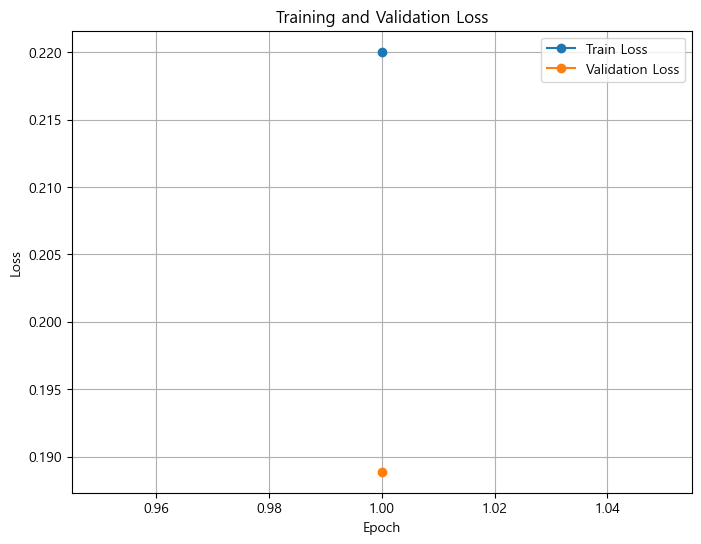

In [14]:
checkpoint = torch.load(save_history_path, map_location=DEVICE)

plt.figure(figsize=(8,6))
plt.plot(range(1, EPOCH+1), checkpoint['loss_history']['train']['total'], label='Train Loss', marker='o')
plt.plot(range(1, EPOCH+1), checkpoint['loss_history']['val']['total'], label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

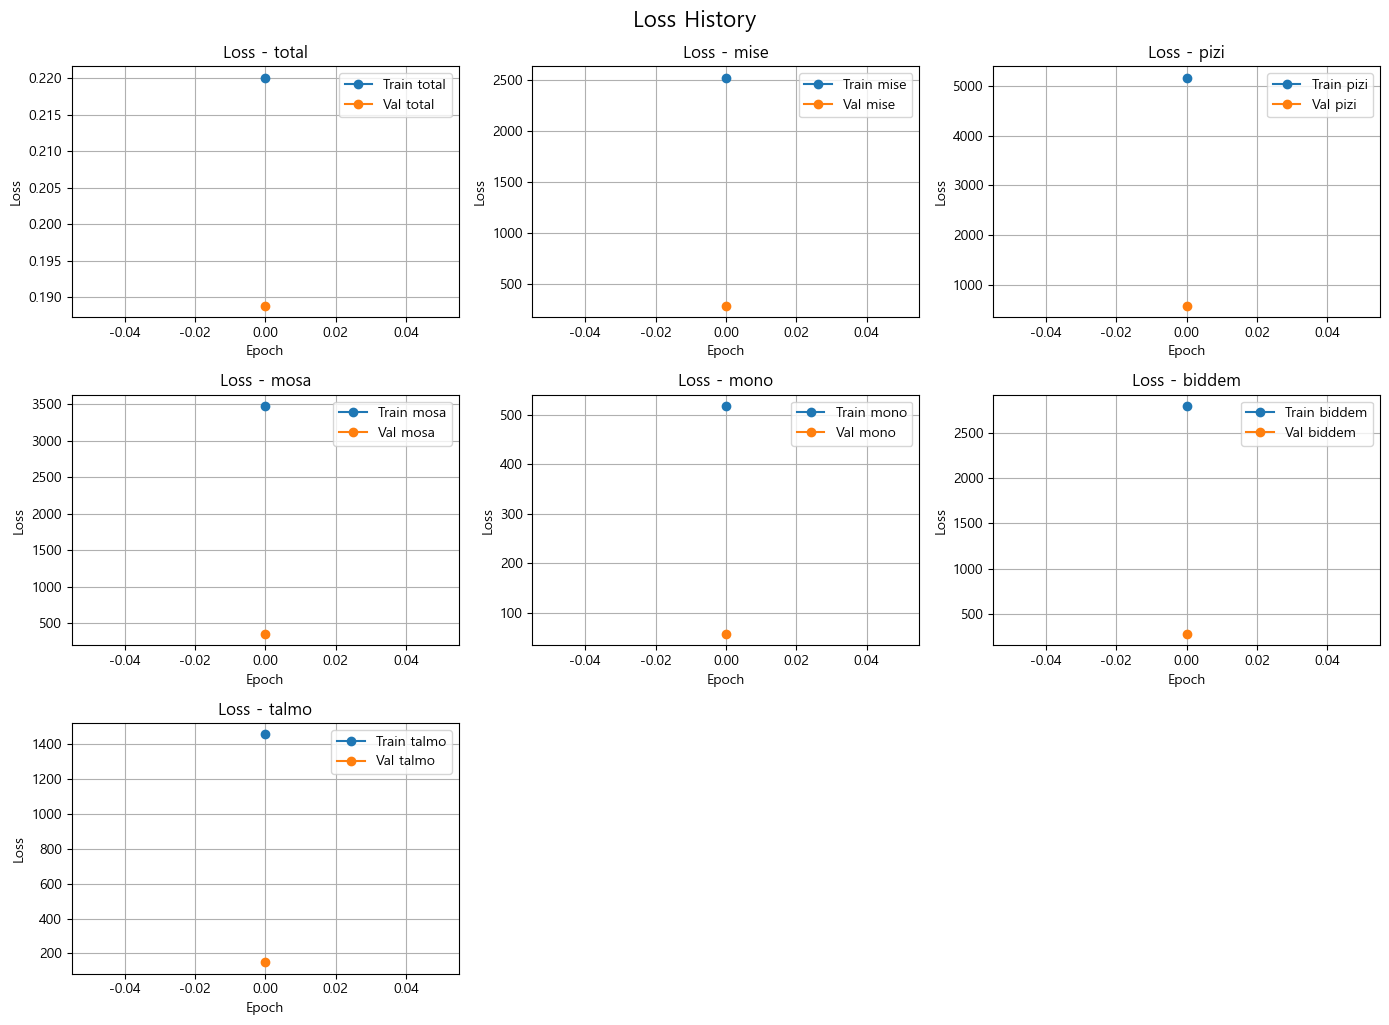

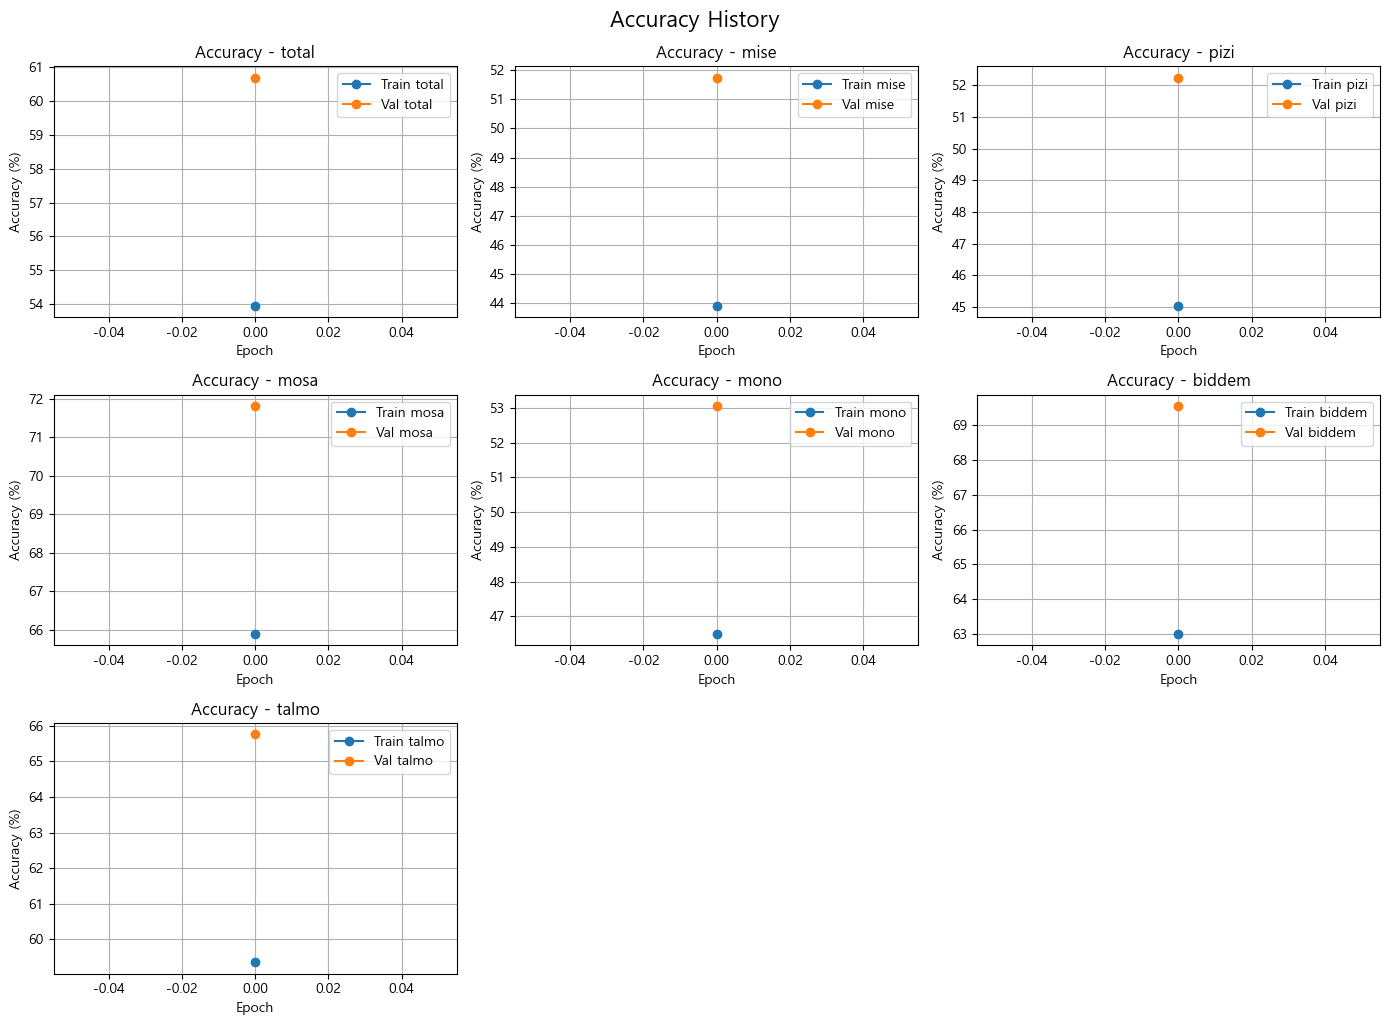

In [15]:
# task 이름 목록
tasks = ['total', 'mise', 'pizi', 'mosa', 'mono', 'biddem', 'talmo']

# loss 시각화
plt.figure(figsize=(14, 10))
for i, task in enumerate(tasks, 1):
    plt.subplot(3, 3, i)
    plt.plot(checkpoint['loss_history']['train'][task], label=f'Train {task}', marker='o')
    plt.plot(checkpoint['loss_history']['val'][task], label=f'Val {task}', marker='o')
    plt.title(f'Loss - {task}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.suptitle('Loss History', fontsize=16, y=1.02)
plt.show()

# accuracy 시각화
plt.figure(figsize=(14, 10))
for i, task in enumerate(tasks, 1):
    plt.subplot(3, 3, i)
    plt.plot(checkpoint['acc_history']['train'][task], label=f'Train {task}', marker='o')
    plt.plot(checkpoint['acc_history']['val'][task], label=f'Val {task}', marker='o')
    plt.title(f'Accuracy - {task}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid()
plt.tight_layout()
plt.suptitle('Accuracy History', fontsize=16, y=1.02)
plt.show()

In [16]:
model = MultiTaskMobileViT(head_channels=64).to(DEVICE)
checkpoint = torch.load(save_model_path, weights_only=False)
model.load_state_dict(checkpoint['model_params'])

model.eval()
test_loss = 0.0
total_samples = 0
overall_correct = 0
task_correct = [0] * 6

with torch.no_grad():
    for inputs, labels in tqdm(test_DL):
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        mise_head, pizi_head, mosa_head, mono_head, biddem_head, talmo_head = model(inputs)

        loss = (criterion_mise(mise_head, labels[:, 0]) +
                criterion_pizi(pizi_head, labels[:, 1]) +
                criterion_mosa(mosa_head, labels[:, 2]) +
                criterion_mono(mono_head, labels[:, 3]) +
                criterion_biddem(biddem_head, labels[:, 4]) +
                criterion_talmo(talmo_head, labels[:, 5]))

        test_loss += loss.item() * inputs.size(0)
        total_samples += inputs.size(0)

        preds = torch.stack([
            mise_head.argmax(dim=1),
            pizi_head.argmax(dim=1),
            mosa_head.argmax(dim=1),
            mono_head.argmax(dim=1),
            biddem_head.argmax(dim=1),
            talmo_head.argmax(dim=1)
        ], dim=1)

        for task in range(6):
            correct_count = (preds[:, task] == labels[:, task]).sum().item()
            task_correct[task] += correct_count
            overall_correct += correct_count

avg_test_loss = test_loss / len(test_DL.dataset)
overall_accuracy = overall_correct / (total_samples * 6)

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Overall Test Accuracy: {overall_accuracy*100:.2f}%")

# 질환 이름 리스트 (요청한 순서대로)
disease_names = [
    "미세각질",
    "피지과다",
    "모낭사이홍반",
    "모낭홍반/농포",
    "비듬",
    "탈모"
]

for task in range(6):
    task_accuracy = task_correct[task] / total_samples
    print(f"{disease_names[task]} Accuracy: {task_accuracy*100:.2f}%")


100%|██████████| 142/142 [00:54<00:00,  2.60it/s]

Test Loss: 0.1934
Overall Test Accuracy: 60.04%
미세각질 Accuracy: 51.33%
피지과다 Accuracy: 52.22%
모낭사이홍반 Accuracy: 70.53%
모낭홍반/농포 Accuracy: 51.69%
비듬 Accuracy: 70.16%
탈모 Accuracy: 64.33%


In [17]:
import pandas as pd

data = {"Model" : [model_type],
    "Test Loss": [round(avg_test_loss, 2)],
    "Overall Test Accuracy": [round(overall_accuracy*100, 2)],
    "미세각질 Accuracy": [round(task_correct[0]/total_samples*100, 2)],
    "피지과다 Accuracy": [round(task_correct[1]/total_samples*100, 2)],
    "모낭사이홍반 Accuracy": [round(task_correct[2]/total_samples*100, 2)],
    "모낭홍반/농포 Accuracy": [round(task_correct[3]/total_samples*100, 2)],
    "비듬 Accuracy": [round(task_correct[4]/total_samples*100, 2)],
    "탈모 Accuracy": [round(task_correct[5]/total_samples*100, 2)]
}

df = pd.DataFrame(data)

if os.path.isfile(save_result_csv_path):
    df.to_csv(save_result_csv_path, mode="a", header=False, index=False)
else:
    df.to_csv(save_result_csv_path, index=False)
    
df

,Model,Test Loss,Overall Test Accuracy,미세각질 Accuracy,피지과다 Accuracy,모낭사이홍반 Accuracy,모낭홍반/농포 Accuracy,비듬 Accuracy,탈모 Accuracy
0,MobileVit-XXS_2025_04_01_14,0.19,60.04,51.33,52.22,70.53,51.69,70.16,64.33


In [18]:
# import os
# import torch
# from PIL import Image

# # 예측할 이미지 파일 경로 (환경에 맞게 수정)
# image_path = r"C:\Users\user1\Desktop\Code\Scalp_Disease_Classifier\data\shin.jpg"
# image = Image.open(image_path).convert("RGB")

# # 데이터 전처리 (data_transforms가 사전에 정의되었다고 가정)
# input_tensor = data_transforms(image).unsqueeze(0).to(device)

# # 모델 평가 모드 전환
# model.eval()

# # 예측 진행
# with torch.no_grad():
#     mise_head, pizi_head, mosa_head, mono_head, biddem_head, talmo_head = model(input_tensor)

#     outputs = torch.stack([mise_head, pizi_head, mosa_head, mono_head, biddem_head, talmo_head], dim=1)
#     probabilities = torch.softmax(outputs, dim=2)
#     predictions = torch.argmax(probabilities, dim=2)

# # 질환 이름 리스트

# disease_names = ["미세각질", "피지과다", "모낭사이홍반", "모낭농포", "비듬", "탈모"]

# # 심각도 매핑
# disease_severity = {0: "양호", 1: "경증", 2: "중등도", 3: "중증"}

# # 결과 출력
# preds = predictions.cpu().numpy()[0]
# probs = probabilities.cpu().numpy()[0]

# for i, (name, pred) in enumerate(zip(disease_names, preds)):
#     severity = disease_severity[pred]
#     confidence = probs[i, pred] * 100
#     print(f"{name}: {severity} ({confidence:.1f}%)")
